# A Continuous-Time Stochastic Lattice Gas Model


Demonstrates a Continuous-Time Stochastic (CTS) Lattice Gas Model. Based on the example Tucker et al. (2016), shown in their Figure 12. Saves individual frames and then generates a gif-format animation called `cts_lattice_gas_movie.gif`.

Requirements:
- Landlab version 2.0beta+
- NumPy
- matplotlib
- imageio

In [1]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from landlab import HexModelGrid
from landlab.ca.celllab_cts import Transition
from landlab.ca.oriented_hex_cts import OrientedHexCTS
%matplotlib inline

In [2]:
def setup_transition_list():
    """
    Creates and returns a list of Transition() objects to represent state
    transitions for simple granular mechanics model.
    
    Parameters
    ----------
    (none)
    
    Returns
    -------
    xn_list : list of Transition objects
        List of objects that encode information about the link-state transitions.
    """
    xn_list = []
    
    # Rule 1: Transitions for particle movement into an empty cell
    xn_list.append( Transition((1,0,0), (0,1,0), 1., 'motion') )
    xn_list.append( Transition((2,0,1), (0,2,1), 1., 'motion') )
    xn_list.append( Transition((3,0,2), (0,3,2), 1., 'motion') )
    xn_list.append( Transition((0,4,0), (4,0,0), 1., 'motion') )
    xn_list.append( Transition((0,5,1), (5,0,1), 1., 'motion') )
    xn_list.append( Transition((0,6,2), (6,0,2), 1., 'motion') )
    
    # Rule 2: Transitions for head-on collision: elastic
    xn_list.append( Transition((1,4,0), (4,1,0), 1./3, 'head-on collision') )
    xn_list.append( Transition((1,4,0), (3,6,0), 1./3, 'head-on collision') )
    xn_list.append( Transition((1,4,0), (5,2,0), 1./3, 'head-on collision') )
    xn_list.append( Transition((2,5,1), (5,2,1), 1./3, 'head-on collision') )
    xn_list.append( Transition((2,5,1), (4,1,1), 1./3, 'head-on collision') )
    xn_list.append( Transition((2,5,1), (6,3,1), 1./3, 'head-on collision') )
    xn_list.append( Transition((3,6,2), (6,3,2), 1./3, 'head-on collision') )
    xn_list.append( Transition((3,6,2), (1,4,2), 1./3, 'head-on collision') )
    xn_list.append( Transition((3,6,2), (5,2,2), 1./3, 'head-on collision') )

    # Rule 3: Transitions for oblique collision: elastic
    xn_list.append( Transition((1,3,0), (3,1,0), 1.0, 'glancing collision') )
    xn_list.append( Transition((1,5,0), (5,1,0), 1.0, 'glancing collision') )
    xn_list.append( Transition((2,4,0), (4,2,0), 1.0, 'glancing collision') )
    xn_list.append( Transition((6,4,0), (4,6,0), 1.0, 'glancing collision') )
    xn_list.append( Transition((2,4,1), (4,2,1), 1.0, 'glancing collision') )
    xn_list.append( Transition((2,6,1), (6,2,1), 1.0, 'glancing collision') )
    xn_list.append( Transition((1,5,1), (5,1,1), 1.0, 'glancing collision') )
    xn_list.append( Transition((3,5,1), (5,3,1), 1.0, 'glancing collision') )
    xn_list.append( Transition((3,1,2), (1,3,2), 1.0, 'glancing collision') )
    xn_list.append( Transition((3,5,2), (5,3,2), 1.0, 'glancing collision') )
    xn_list.append( Transition((2,6,2), (6,2,2), 1.0, 'glancing collision') )
    xn_list.append( Transition((4,6,2), (6,4,2), 1.0, 'glancing collision') )

    # Rule 4: Transitions for oblique-from-behind collisions
    xn_list.append( Transition((1,2,0), (2,1,0), 1.0, 'oblique') )
    xn_list.append( Transition((1,6,0), (6,1,0), 1.0, 'oblique') )
    xn_list.append( Transition((3,4,0), (4,3,0), 1.0, 'oblique') )
    xn_list.append( Transition((5,4,0), (4,5,0), 1.0, 'oblique') )
    xn_list.append( Transition((2,1,1), (1,2,1), 1.0, 'oblique') )
    xn_list.append( Transition((2,3,1), (3,2,1), 1.0, 'oblique') )
    xn_list.append( Transition((4,5,1), (5,4,1), 1.0, 'oblique') )
    xn_list.append( Transition((6,5,1), (5,6,1), 1.0, 'oblique') )
    xn_list.append( Transition((3,2,2), (2,3,2), 1.0, 'oblique') )
    xn_list.append( Transition((3,4,2), (4,3,2), 1.0, 'oblique') )
    xn_list.append( Transition((1,6,2), (6,1,2), 1.0, 'oblique') )
    xn_list.append( Transition((5,6,2), (6,5,2), 1.0, 'oblique') )
    
    # Rule 5: Transitions for direct-from-behind collisions
    xn_list.append( Transition((1,1,0), (2,6,0), 0.25, 'behind') )
    xn_list.append( Transition((1,1,0), (6,2,0), 0.25, 'behind') )
    xn_list.append( Transition((4,4,0), (3,5,0), 0.25, 'behind') )
    xn_list.append( Transition((4,4,0), (5,3,0), 0.25, 'behind') )
    xn_list.append( Transition((2,2,1), (1,3,1), 0.25, 'behind') )
    xn_list.append( Transition((2,2,1), (3,1,1), 0.25, 'behind') )
    xn_list.append( Transition((5,5,1), (4,6,1), 0.25, 'behind') )
    xn_list.append( Transition((5,5,1), (6,4,1), 0.25, 'behind') )
    xn_list.append( Transition((3,3,2), (2,4,2), 0.25, 'behind') )
    xn_list.append( Transition((3,3,2), (4,2,2), 0.25, 'behind') )
    xn_list.append( Transition((6,6,2), (1,5,2), 0.25, 'behind') )
    xn_list.append( Transition((6,6,2), (5,1,2), 0.25, 'behind') )
    
    # Rule 6: Transitions for direct collision with stationary (resting) particle
    xn_list.append( Transition((1,7,0), (7,1,0), 1./3., 'rest') )
    xn_list.append( Transition((1,7,0), (7,2,0), 1./3., 'rest') )
    xn_list.append( Transition((1,7,0), (7,6,0), 1./3., 'rest') )
    xn_list.append( Transition((7,4,0), (4,7,0), 1./3., 'rest') )
    xn_list.append( Transition((7,4,0), (3,7,0), 1./3., 'rest') )
    xn_list.append( Transition((7,4,0), (5,7,0), 1./3., 'rest') )
    xn_list.append( Transition((2,7,1), (7,2,1), 1./3., 'rest') )
    xn_list.append( Transition((2,7,1), (7,1,1), 1./3., 'rest') )
    xn_list.append( Transition((2,7,1), (7,3,1), 1./3., 'rest') )
    xn_list.append( Transition((7,5,1), (5,7,1), 1./3., 'rest') )
    xn_list.append( Transition((7,5,1), (4,7,1), 1./3., 'rest') )
    xn_list.append( Transition((7,5,1), (6,7,1), 1./3., 'rest') )
    xn_list.append( Transition((3,7,2), (7,3,2), 1./3., 'rest') )
    xn_list.append( Transition((3,7,2), (7,2,2), 1./3., 'rest') )
    xn_list.append( Transition((3,7,2), (7,4,2), 1./3., 'rest') )
    xn_list.append( Transition((7,6,2), (6,7,2), 1./3., 'rest') )
    xn_list.append( Transition((7,6,2), (1,7,2), 1./3., 'rest') )
    xn_list.append( Transition((7,6,2), (5,7,2), 1./3., 'rest') )

    # Rule 7: Transitions for wall impact
    xn_list.append( Transition((1,8,0), (4,8,0), 1.0/3, 'wall rebound') )
    xn_list.append( Transition((1,8,0), (3,8,0), 1.0/3, 'wall rebound') )
    xn_list.append( Transition((1,8,0), (5,8,0), 1.0/3, 'wall rebound') )
    xn_list.append( Transition((2,8,1), (5,8,1), 1.0/3, 'wall rebound') )
    xn_list.append( Transition((2,8,1), (4,8,1), 1.0/3, 'wall rebound') )
    xn_list.append( Transition((2,8,1), (6,8,1), 1.0/3, 'wall rebound') )
    xn_list.append( Transition((3,8,2), (6,8,2), 1.0/3, 'wall rebound') )
    xn_list.append( Transition((3,8,2), (5,8,2), 1.0/3, 'wall rebound') )
    xn_list.append( Transition((3,8,2), (1,8,2), 1.0/3, 'wall rebound') )
    xn_list.append( Transition((8,4,0), (8,1,0), 1.0/3, 'wall rebound') )
    xn_list.append( Transition((8,4,0), (8,6,0), 1.0/3, 'wall rebound') )
    xn_list.append( Transition((8,4,0), (8,2,0), 1.0/3, 'wall rebound') )
    xn_list.append( Transition((8,5,1), (8,1,1), 1.0/3, 'wall rebound') )
    xn_list.append( Transition((8,5,1), (8,2,1), 1.0/3, 'wall rebound') )
    xn_list.append( Transition((8,5,1), (8,3,1), 1.0/3, 'wall rebound') )
    xn_list.append( Transition((8,6,2), (8,2,2), 1.0/3, 'wall rebound') )
    xn_list.append( Transition((8,6,2), (8,3,2), 1.0/3, 'wall rebound') )
    xn_list.append( Transition((8,6,2), (8,4,2), 1.0/3, 'wall rebound') )

    # Rule 8: Transitions for glancing oblique collision
    xn_list.append( Transition((2,5,0), (3,6,0), 1.0, 'glancing') )
    xn_list.append( Transition((6,3,0), (5,2,0), 1.0, 'glancing') )
    xn_list.append( Transition((3,6,1), (4,1,1), 1.0, 'glancing') )
    xn_list.append( Transition((1,4,1), (6,3,1), 1.0, 'glancing') )
    xn_list.append( Transition((4,1,2), (5,2,2), 1.0, 'glancing') )
    xn_list.append( Transition((2,5,2), (1,4,2), 1.0, 'glancing') )
    
    # Rule 9: Transitions for "near-on" collisions
    xn_list.append( Transition((6,5,0), (5,6,0), 1.0, 'near-on') )
    xn_list.append( Transition((2,3,0), (3,2,0), 1.0, 'near-on') )
    xn_list.append( Transition((1,6,1), (6,1,1), 1.0, 'near-on') )
    xn_list.append( Transition((3,4,1), (4,3,1), 1.0, 'near-on') )
    xn_list.append( Transition((2,1,2), (1,2,2), 1.0, 'near-on') )
    xn_list.append( Transition((4,5,2), (5,4,2), 1.0, 'near-on') )
    
    # Rule 10: Transitions for oblique collision with rest particle
    xn_list.append( Transition((2,7,0), (7,1,0), 1.0, 'oblique with rest') )
    xn_list.append( Transition((6,7,0), (7,1,0), 1.0, 'oblique with rest') )
    xn_list.append( Transition((7,3,0), (4,7,0), 1.0, 'oblique with rest') )
    xn_list.append( Transition((7,5,0), (4,7,0), 1.0, 'oblique with rest') )
    xn_list.append( Transition((3,7,1), (7,2,1), 1.0, 'oblique with rest') )
    xn_list.append( Transition((1,7,1), (7,2,1), 1.0, 'oblique with rest') )
    xn_list.append( Transition((7,6,1), (5,7,1), 1.0, 'oblique with rest') )
    xn_list.append( Transition((7,4,1), (5,7,1), 1.0, 'oblique with rest') )
    xn_list.append( Transition((4,7,2), (7,3,2), 1.0, 'oblique with rest') )
    xn_list.append( Transition((2,7,2), (7,3,2), 1.0, 'oblique with rest') )
    xn_list.append( Transition((7,5,2), (6,7,2), 1.0, 'oblique with rest') )
    xn_list.append( Transition((7,1,2), (6,7,2), 1.0, 'oblique with rest') )

    # Rule 11: Transitions for oblique collision with wall particle
    xn_list.append( Transition((2,8,0), (3,8,0), 1.0, 'oblique with wall') )
    xn_list.append( Transition((6,8,0), (5,8,0), 1.0, 'oblique with wall') )
    xn_list.append( Transition((8,3,0), (8,2,0), 1.0, 'oblique with wall') )
    xn_list.append( Transition((8,5,0), (8,6,0), 1.0, 'oblique with wall') )
    xn_list.append( Transition((1,8,1), (6,8,1), 1.0, 'oblique with wall') )
    xn_list.append( Transition((3,8,1), (4,8,1), 1.0, 'oblique with wall') )
    xn_list.append( Transition((8,4,1), (8,3,1), 1.0, 'oblique with wall') )
    xn_list.append( Transition((8,6,1), (8,1,1), 1.0, 'oblique with wall') )
    xn_list.append( Transition((4,8,2), (5,8,2), 1.0, 'oblique with wall') )
    xn_list.append( Transition((2,8,2), (1,8,2), 1.0, 'oblique with wall') )
    xn_list.append( Transition((8,1,2), (8,2,2), 1.0, 'oblique with wall') )
    xn_list.append( Transition((8,5,2), (8,4,2), 1.0, 'oblique with wall') )

    return xn_list


In [3]:
def plot_vessel(grid, filename=None, array=None, cmap=None):
    """Generate a plot of the modeled vessel."""
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    # Set color map
    if cmap is None:
        cmap = 'tab10'

    if array is None:
        array = grid.at_node["node_state"]

    # Generate the plot
    plt.clf()
    ax = grid.hexplot(array, color_map=cmap)
    ax.set_aspect("equal")
    ax.axis(False)

    # If requested, save the plot to a file
    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")
        print("Figure saved to " + filename)

In [4]:
def make_gif_anim(basename):
    import imageio
    import os

    images = []

    for this_name in sorted(os.listdir('.')):
        if this_name[-3:] == 'png':
            print('appending ' + this_name)
            images.append(imageio.imread(this_name))
    imageio.mimsave(basename + '_movie.gif', images)

In [5]:
def main():
    
    # INITIALIZE
    
    # User-defined parameters
    nr = 52
    nc = 120
    plot_interval = 10.0
    run_duration = 1000.0
    report_interval = 5.0  # report interval, in real-time seconds
    p_init = 0.1  # probability that a cell is occupied at start
    plot_every_transition = False
    
    # Remember the clock time, and calculate when we next want to report
    # progress.
    current_real_time = time.time()
    next_report = current_real_time + report_interval

    # Create a grid
    hmg = HexModelGrid((nr, nc), 1.0, orientation='vertical', reorient_links=True)
    
    # Set up the states and pair transitions.
    # Transition data here represent particles moving on a lattice: one state
    # per direction (for 6 directions), plus an empty state, a stationary
    # state, and a wall state.
    ns_dict = { 0 : 'empty', 
                1 : 'moving up',
                2 : 'moving right and up',
                3 : 'moving right and down',
                4 : 'moving down',
                5 : 'moving left and down',
                6 : 'moving left and up',
                7 : 'rest',
                8 : 'wall'}
    xn_list = setup_transition_list()

    # Create data and initialize values.
    node_state_grid = hmg.add_zeros('node', 'node_state_grid', dtype=int)
    
    # Make the grid boundary all wall particles
    node_state_grid[hmg.boundary_nodes] = 8
    
    # Seed the grid interior with randomly oriented particles
    for i in hmg.core_nodes:
        if random.random()<p_init:
            node_state_grid[i] = random.randint(1, 7)
    
    # Create the CA model
    ca = OrientedHexCTS(hmg, ns_dict, xn_list, node_state_grid)
    
    # Set up a color map for plotting
    import matplotlib
    clist = [ (1.0, 1.0, 1.0),   # empty = white
              (1.0, 0.0, 0.0),   # up = red
              (0.8, 0.8, 0.0),   # right-up = yellow
              (0.0, 1.0, 0.0),   # down-up = green
              (0.0, 1.0, 1.0),   # down = cyan
              (0.0, 0.0, 1.0),   # left-down = blue
              (1.0, 0.0, 1.0),   # left-up = magenta
              (0.5, 0.5, 0.5),   # resting = gray
              (0.0, 0.0, 0.0) ]   # wall = black
    line_styles = [ '',
                    '-',
                    '--',
                    '--',
                    '-',
                    '-.',
                    '--',
                    '-',
                    ':']
    my_cmap = matplotlib.colors.ListedColormap(clist)

    # Set up plotting
    plot_number = 1
    
    # Plot the initial grid
    plot_vessel(hmg, 'cts_lattice_gas000.png', array=None, cmap=my_cmap)

    # Create an array to store the numbers of states at each plot interval
    nstates = np.zeros((9, int(run_duration/plot_interval)))
    k = 0

    # RUN
    current_time = 0.0
    while current_time < run_duration:
        
        # Once in a while, print out simulation and real time to let the user
        # know that the sim is running ok
        current_real_time = time.time()
        if current_real_time >= next_report:
            print('Current sim time',current_time,'(',100*current_time/run_duration,'%)')
            next_report = current_real_time + report_interval
        
        # Run the model forward in time until the next output step
        ca.run(current_time+plot_interval, ca.node_state, 
               plot_each_transition=plot_every_transition)
        current_time += plot_interval
        
        # Plot the current grid
        plot_vessel(hmg, 'cts_lattice_gas' + str(plot_number).zfill(3) + '.png',
                    array=None, cmap=my_cmap)
        plt.show()
        plot_number += 1

        # Record numbers in each state
        nstates[:,k] = np.bincount(node_state_grid)
        k += 1

    # FINALIZE

    # Display the numbers of each state
    #fig, ax = subplots()
    #for i in range(1, 8):
    #    plot(arange(plot_interval, run_duration+plot_interval, plot_interval), \
    #         nstates[i,:], label=ns_dict[i], color=clist[i], linestyle=line_styles[i])
    #ax.legend()
    #xlabel('Time')
    #ylabel('Number of particles in state')
    #title('Particle distribution by state')
    #axis([0, run_duration, 0, 2*nstates[7,0]])
    #show()



Figure saved to cts_lattice_gas000.png
Current sim time 0.0 ( 0.0 %)
Figure saved to cts_lattice_gas001.png


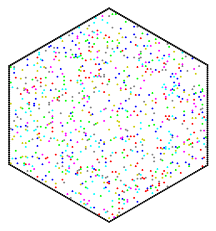

Figure saved to cts_lattice_gas002.png


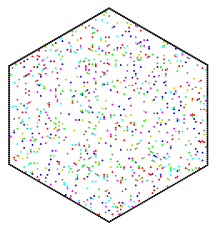

Figure saved to cts_lattice_gas003.png


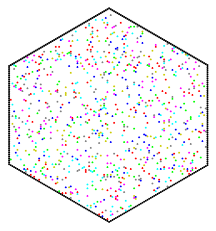

Figure saved to cts_lattice_gas004.png


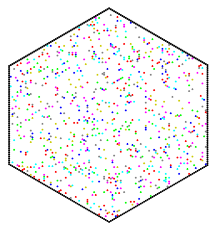

Figure saved to cts_lattice_gas005.png


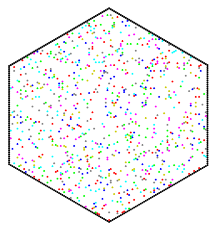

Figure saved to cts_lattice_gas006.png


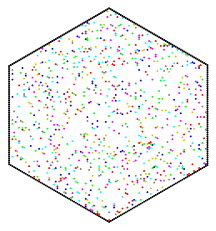

Figure saved to cts_lattice_gas007.png


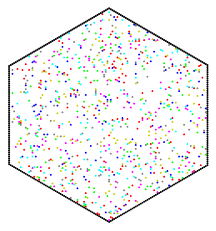

Current sim time 70.0 ( 7.0 %)
Figure saved to cts_lattice_gas008.png


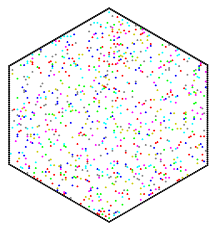

Figure saved to cts_lattice_gas009.png


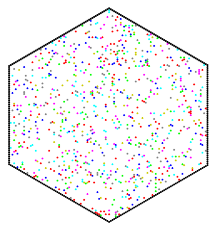

Figure saved to cts_lattice_gas010.png


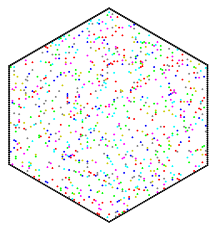

Figure saved to cts_lattice_gas011.png


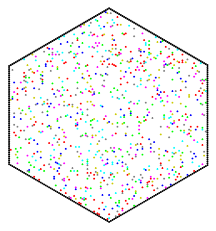

Figure saved to cts_lattice_gas012.png


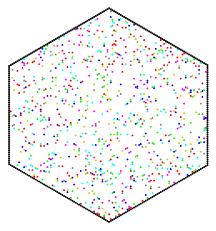

Figure saved to cts_lattice_gas013.png


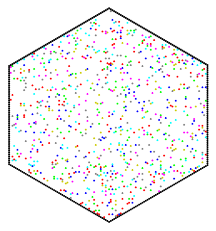

Figure saved to cts_lattice_gas014.png


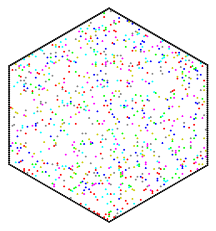

Current sim time 140.0 ( 14.0 %)
Figure saved to cts_lattice_gas015.png


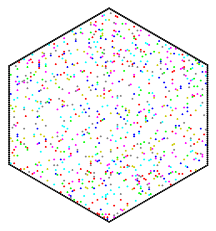

Figure saved to cts_lattice_gas016.png


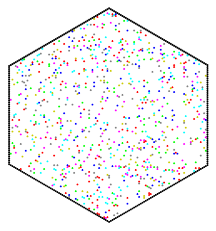

Figure saved to cts_lattice_gas017.png


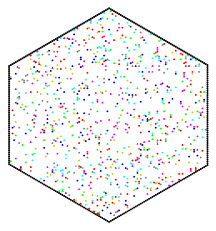

Figure saved to cts_lattice_gas018.png


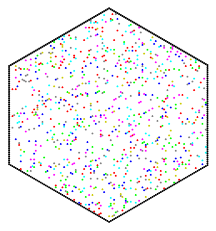

Figure saved to cts_lattice_gas019.png


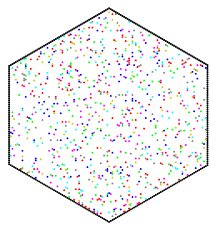

Figure saved to cts_lattice_gas020.png


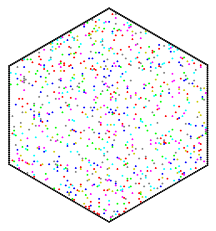

Figure saved to cts_lattice_gas021.png


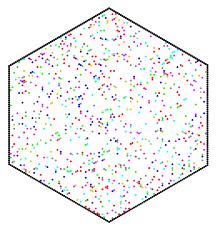

Current sim time 210.0 ( 21.0 %)
Figure saved to cts_lattice_gas022.png


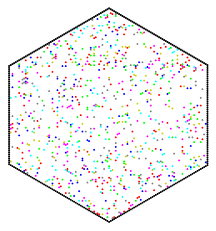

Figure saved to cts_lattice_gas023.png


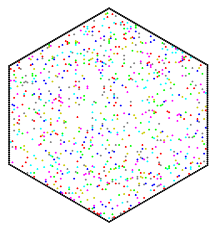

Figure saved to cts_lattice_gas024.png


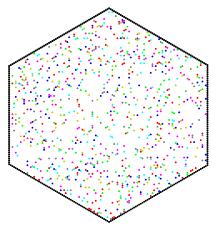

Figure saved to cts_lattice_gas025.png


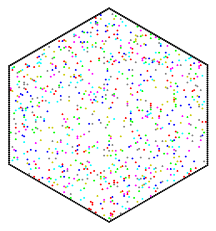

Figure saved to cts_lattice_gas026.png


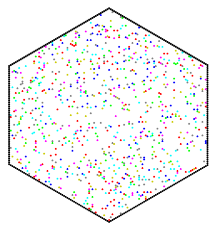

Figure saved to cts_lattice_gas027.png


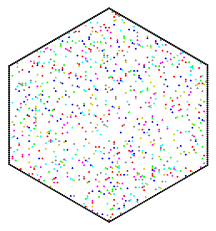

Figure saved to cts_lattice_gas028.png


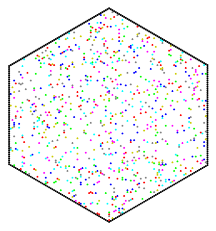

Current sim time 280.0 ( 28.0 %)
Figure saved to cts_lattice_gas029.png


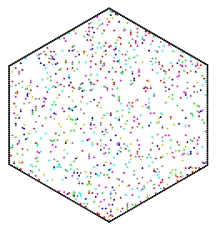

Figure saved to cts_lattice_gas030.png


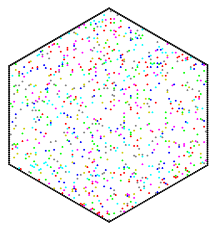

Figure saved to cts_lattice_gas031.png


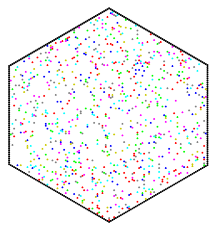

Figure saved to cts_lattice_gas032.png


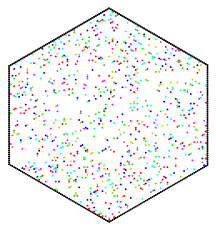

Figure saved to cts_lattice_gas033.png


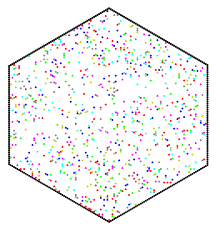

Figure saved to cts_lattice_gas034.png


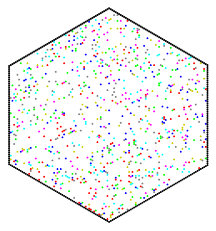

Figure saved to cts_lattice_gas035.png


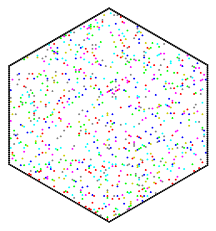

Current sim time 350.0 ( 35.0 %)
Figure saved to cts_lattice_gas036.png


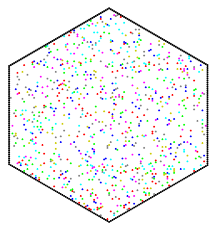

Figure saved to cts_lattice_gas037.png


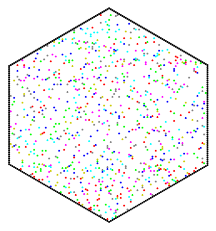

Figure saved to cts_lattice_gas038.png


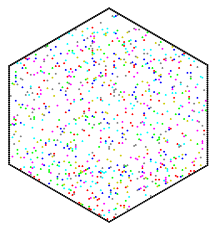

Figure saved to cts_lattice_gas039.png


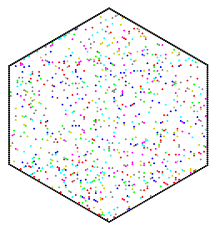

Figure saved to cts_lattice_gas040.png


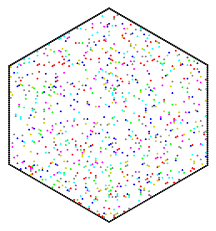

Figure saved to cts_lattice_gas041.png


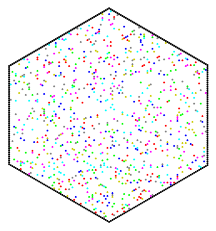

Figure saved to cts_lattice_gas042.png


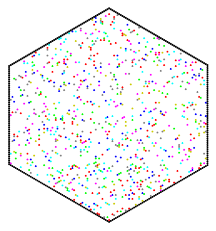

Current sim time 420.0 ( 42.0 %)
Figure saved to cts_lattice_gas043.png


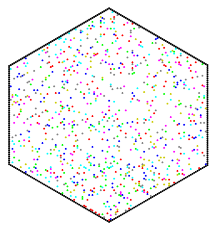

Figure saved to cts_lattice_gas044.png


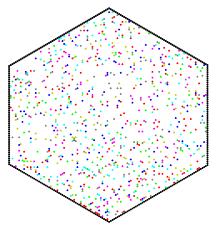

Figure saved to cts_lattice_gas045.png


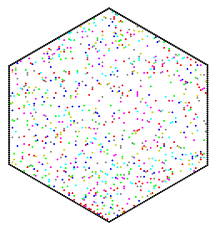

Figure saved to cts_lattice_gas046.png


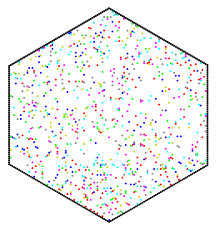

Figure saved to cts_lattice_gas047.png


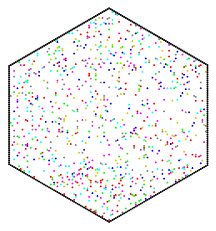

Figure saved to cts_lattice_gas048.png


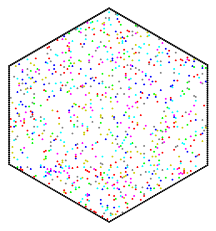

Figure saved to cts_lattice_gas049.png


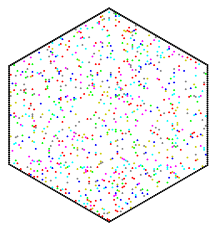

Current sim time 490.0 ( 49.0 %)
Figure saved to cts_lattice_gas050.png


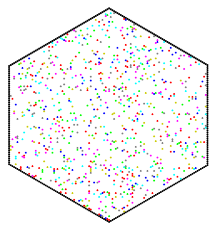

Figure saved to cts_lattice_gas051.png


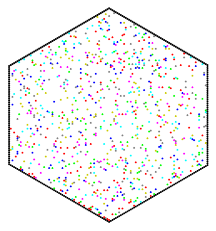

Figure saved to cts_lattice_gas052.png


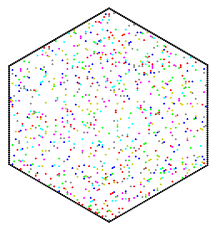

Figure saved to cts_lattice_gas053.png


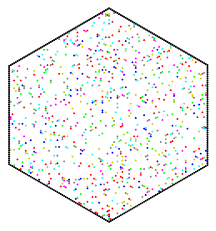

Figure saved to cts_lattice_gas054.png


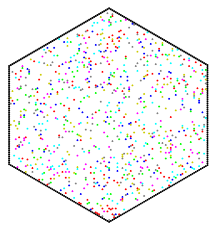

Figure saved to cts_lattice_gas055.png


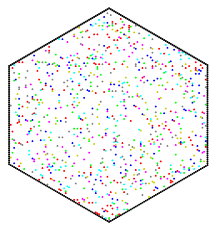

Figure saved to cts_lattice_gas056.png


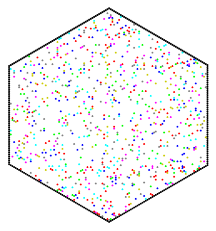

Current sim time 560.0 ( 56.0 %)
Figure saved to cts_lattice_gas057.png


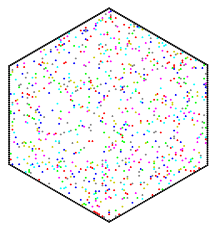

Figure saved to cts_lattice_gas058.png


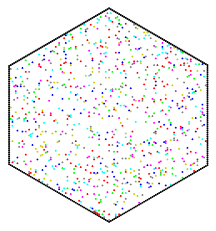

Figure saved to cts_lattice_gas059.png


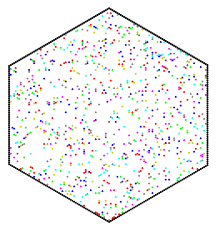

Figure saved to cts_lattice_gas060.png


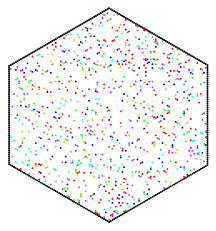

Figure saved to cts_lattice_gas061.png


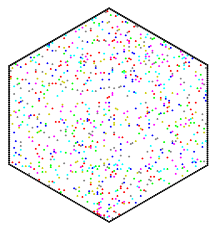

Figure saved to cts_lattice_gas062.png


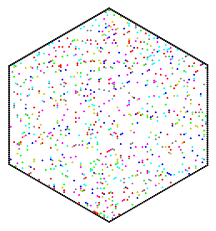

Figure saved to cts_lattice_gas063.png


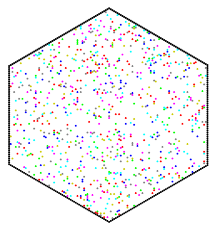

Current sim time 630.0 ( 63.0 %)
Figure saved to cts_lattice_gas064.png


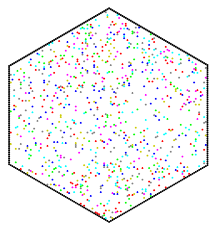

Figure saved to cts_lattice_gas065.png


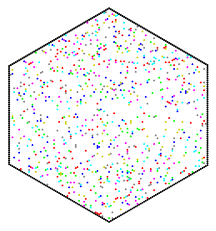

Figure saved to cts_lattice_gas066.png


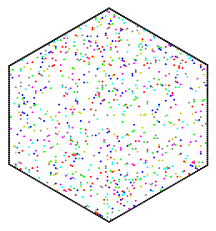

Figure saved to cts_lattice_gas067.png


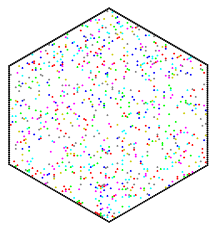

Figure saved to cts_lattice_gas068.png


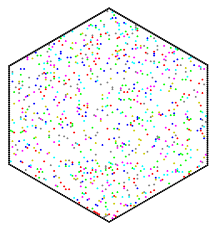

Figure saved to cts_lattice_gas069.png


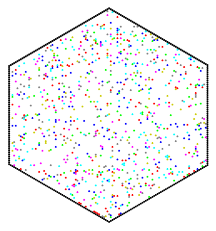

Figure saved to cts_lattice_gas070.png


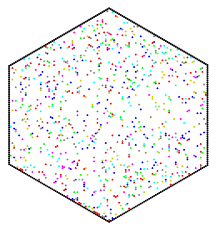

Current sim time 700.0 ( 70.0 %)
Figure saved to cts_lattice_gas071.png


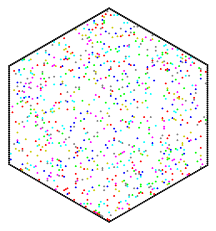

Figure saved to cts_lattice_gas072.png


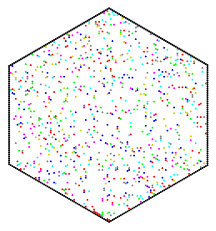

Figure saved to cts_lattice_gas073.png


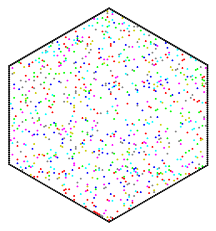

Figure saved to cts_lattice_gas074.png


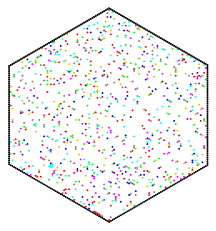

Figure saved to cts_lattice_gas075.png


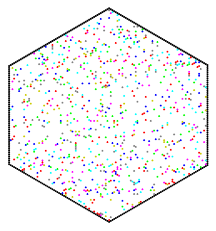

Figure saved to cts_lattice_gas076.png


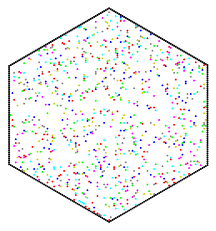

Figure saved to cts_lattice_gas077.png


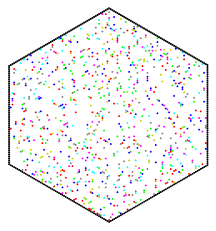

Current sim time 770.0 ( 77.0 %)
Figure saved to cts_lattice_gas078.png


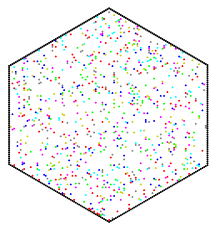

Figure saved to cts_lattice_gas079.png


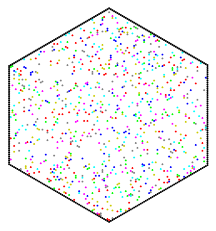

Figure saved to cts_lattice_gas080.png


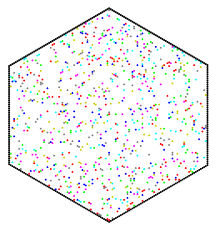

Figure saved to cts_lattice_gas081.png


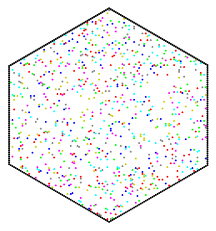

Figure saved to cts_lattice_gas082.png


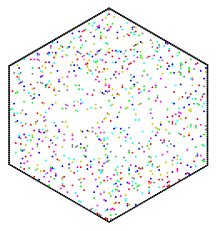

Figure saved to cts_lattice_gas083.png


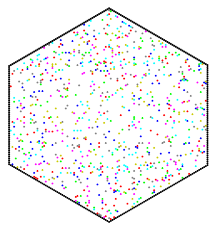

Figure saved to cts_lattice_gas084.png


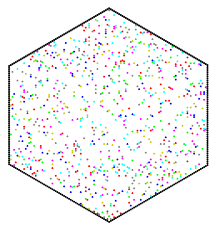

Current sim time 840.0 ( 84.0 %)
Figure saved to cts_lattice_gas085.png


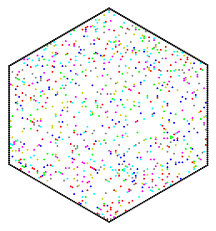

Figure saved to cts_lattice_gas086.png


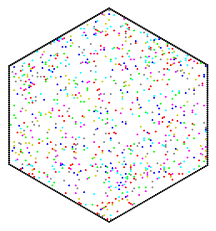

Figure saved to cts_lattice_gas087.png


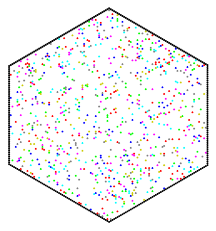

Figure saved to cts_lattice_gas088.png


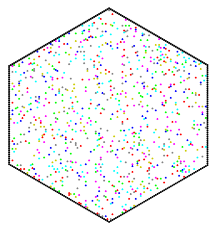

Figure saved to cts_lattice_gas089.png


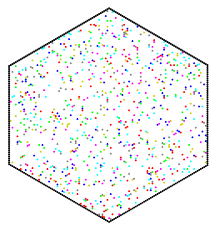

Figure saved to cts_lattice_gas090.png


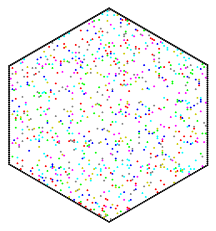

Figure saved to cts_lattice_gas091.png


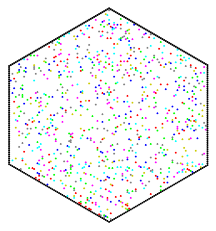

Current sim time 910.0 ( 91.0 %)
Figure saved to cts_lattice_gas092.png


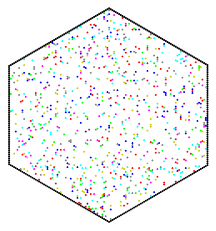

Figure saved to cts_lattice_gas093.png


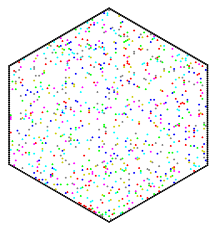

Figure saved to cts_lattice_gas094.png


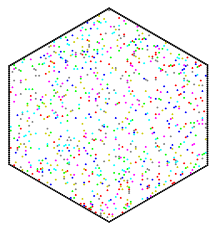

Figure saved to cts_lattice_gas095.png


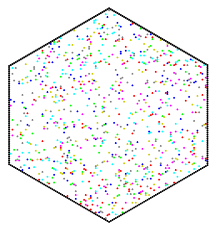

Figure saved to cts_lattice_gas096.png


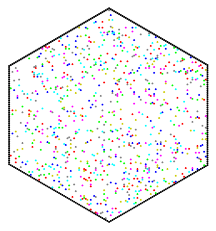

Figure saved to cts_lattice_gas097.png


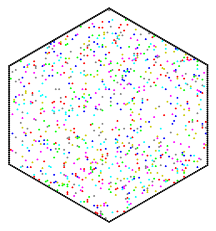

Figure saved to cts_lattice_gas098.png


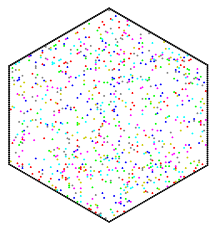

Current sim time 980.0 ( 98.0 %)
Figure saved to cts_lattice_gas099.png


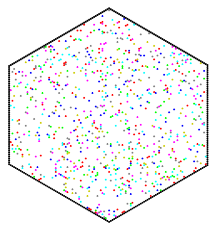

Figure saved to cts_lattice_gas100.png


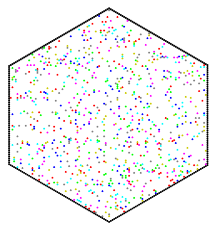

In [6]:
main()

In [7]:
make_gif_anim('cts_lattice_gas')

appending cts_lattice_gas000.png
appending cts_lattice_gas001.png
appending cts_lattice_gas002.png
appending cts_lattice_gas003.png
appending cts_lattice_gas004.png
appending cts_lattice_gas005.png
appending cts_lattice_gas006.png
appending cts_lattice_gas007.png
appending cts_lattice_gas008.png
appending cts_lattice_gas009.png
appending cts_lattice_gas010.png
appending cts_lattice_gas011.png
appending cts_lattice_gas012.png
appending cts_lattice_gas013.png
appending cts_lattice_gas014.png
appending cts_lattice_gas015.png
appending cts_lattice_gas016.png
appending cts_lattice_gas017.png
appending cts_lattice_gas018.png
appending cts_lattice_gas019.png
appending cts_lattice_gas020.png
appending cts_lattice_gas021.png
appending cts_lattice_gas022.png
appending cts_lattice_gas023.png
appending cts_lattice_gas024.png
appending cts_lattice_gas025.png
appending cts_lattice_gas026.png
appending cts_lattice_gas027.png
appending cts_lattice_gas028.png
appending cts_lattice_gas029.png
appending 